# ANN to Predict Subject
Using modal representation, can we tell which subject it came from?

If so, perhaps there is structure here.

This is the robust one for paper results

Setup: Javascript and ipynb stuff

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## Load Functions

In [4]:
from fastai.vision import *
import os
import numpy as np
import pandas as pd
import pickle
import warnings; warnings.simplefilter('ignore')

In [5]:
path=pathlib.Path('/home/tris/Documents/EEG_data/DMD_DEAP')
path

PosixPath('/home/tris/Documents/EEG_data/DMD_DEAP')

## Load Original Data Labels

In [6]:
path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s01.dat'
df_read = pickle.load(open(path, 'rb'), encoding='latin1')
labels=df_read['labels']
df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
df=df_tmp
for n in range (2,10):
    path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s0'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True)
for n in range (10,33):
    path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True) 

In [7]:
df=df.div(9) #normalize
df.head()

,valence,arousal,dominance,liking
0,0.856667,0.844444,0.766667,0.870000
1,0.900000,0.812222,0.808889,0.941111
2,0.953333,0.837778,1.000000,0.786667
3,0.548889,0.667778,0.680000,0.895556
4,0.773333,0.435556,0.798889,0.672222


## Set filenames and labels

In [8]:
df=pd.DataFrame()
filenames=[]
subject_labels=[]
for n in range (0,9):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
    for i in range (9,40):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
for n in range (9,32):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
    for i in range (9,40):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
df['file_name']=filenames
df['subject_label']=subject_labels
# df=df[['file_name','valence','arousal','dominance','liking']]
df=df[['file_name','subject_label']]
df.tail()

,file_name,subject_label
1275,S32T36,32
1276,S32T37,32
1277,S32T38,32
1278,S32T39,32
1279,S32T40,32


In [9]:
# for i in range(1,33):
#     for ii in range(1,41):
#         os.rename(r'/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/T'+str(ii)+'S'+str(i)+".png",r'/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/S'+str(i)+'T'+str(ii)+".png")

In [10]:
# from PIL import Image

# for i in range (0,1280):
    
#     im = Image.open(r"/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/"+str(df.file_name[i])+".png")
#     im1=im.crop((0,0,1450,1030))
#     im1.save("/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps_re/"+str(df.file_name[i])+".png")

In [11]:
path=pathlib.Path('/media/tris/tris_files/EEG_datasets/robots')
path

PosixPath('/media/tris/tris_files/EEG_datasets/robots')

In [12]:
df.to_csv(path/'labels_proc.csv', index=False)

In [13]:
df = pd.read_csv(path/'labels_proc.csv') #load labels
df.tail()

,file_name,subject_label
1275,S32T36,32
1276,S32T37,32
1277,S32T38,32
1278,S32T39,32
1279,S32T40,32


## Data loader

In [14]:
src = (ImageList.from_csv(path, 'labels_proc.csv', folder='heatmaps_15', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(cols=['subject_label'],label_cls=CategoryList))

In [15]:
tfms=[]

In [16]:
data = (src.transform(tfms, size=200)
        .databunch(bs=4).normalize())

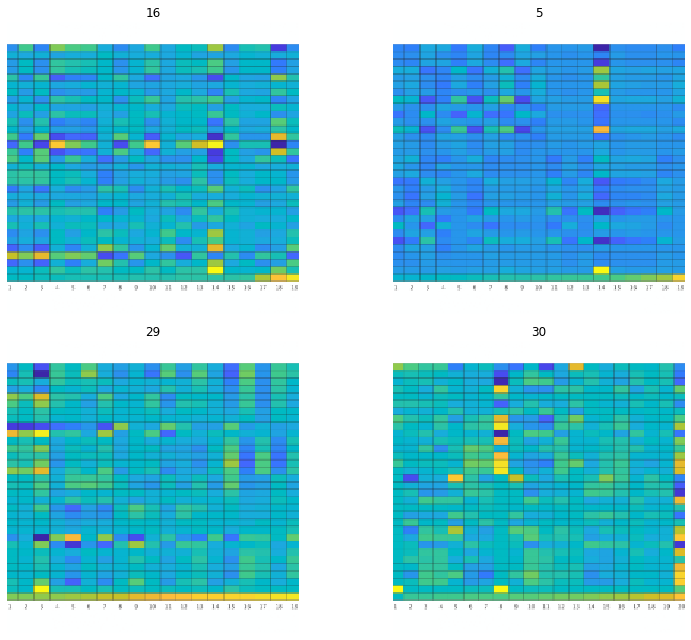

In [17]:
data.show_batch(rows=4, figsize=(12,9))

## Setup Network

In [18]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [19]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 100, 100]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 100, 100]       128        True      
______________________________________________________________________
ReLU                 [64, 100, 100]       0          False     
______________________________________________________________________
MaxPool2d            [64, 50, 50]         0          False     
______________________________________________________________________
Conv2d               [64, 50, 50]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 50, 50]         128        True      
______________________________________________________________________
ReLU                 [64, 50, 50]         0          False     
___________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


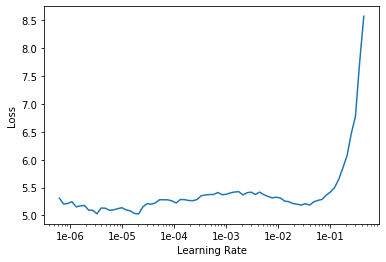

In [20]:
learn.lr_find()
learn.recorder.plot()

## Train last layers

In [21]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,3.960051,2.341291,0.339844,00:13
1,2.385040,1.003609,0.699219,00:13
2,1.694586,0.791107,0.777344,00:13
3,1.292954,0.655733,0.808594,00:13
4,1.068754,0.598608,0.828125,00:14


In [22]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.985721,0.595537,0.832031,00:14
1,1.023926,0.547722,0.847656,00:13
2,0.952633,0.436995,0.882812,00:13
3,0.700321,0.386240,0.886719,00:13
4,0.728176,0.367381,0.914062,00:13


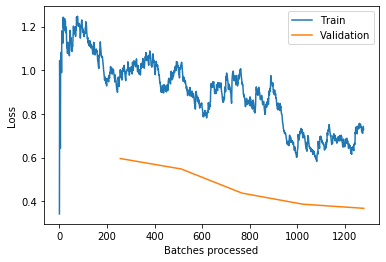

In [23]:
learn.recorder.plot_losses()

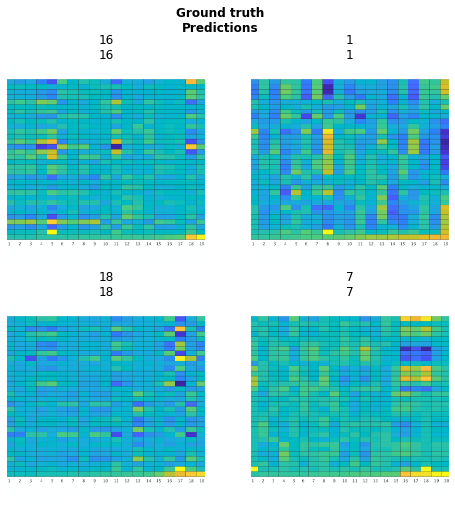

In [24]:
learn.show_results()

## Train the whole network

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


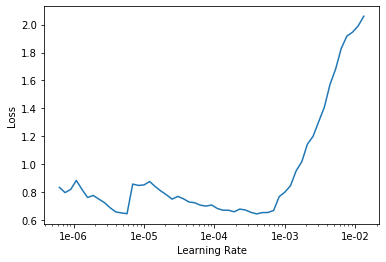

In [25]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [26]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.180631,1.118900,0.656250,00:14
1,1.461247,0.527344,0.851562,00:14
2,0.792814,0.246170,0.929688,00:14
3,0.496969,0.111602,0.972656,00:14
4,0.283358,0.083065,0.980469,00:14


In [29]:
learn.fit_one_cycle(1, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.340501,0.065457,0.984375,00:14


## Interpret and Results

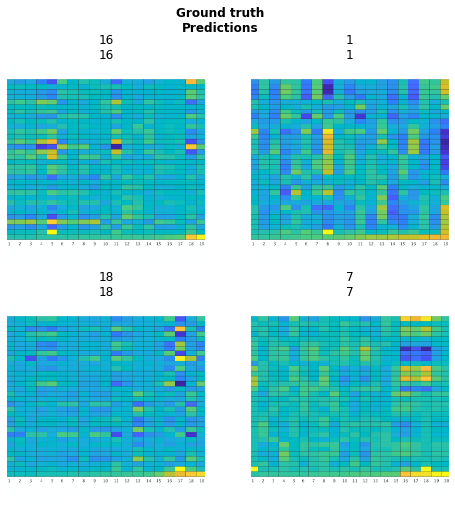

In [30]:
learn.show_results()

In [31]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [32]:
interp.confusion_matrix()

array([[11,  0,  0,  0, ...,  0,  0,  0,  0],
       [ 0,  8,  0,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  9,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  0,  4, ...,  0,  0,  0,  0],
       ...,
       [ 0,  0,  0,  0, ...,  9,  0,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  7,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  0, 10,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  0,  7]])

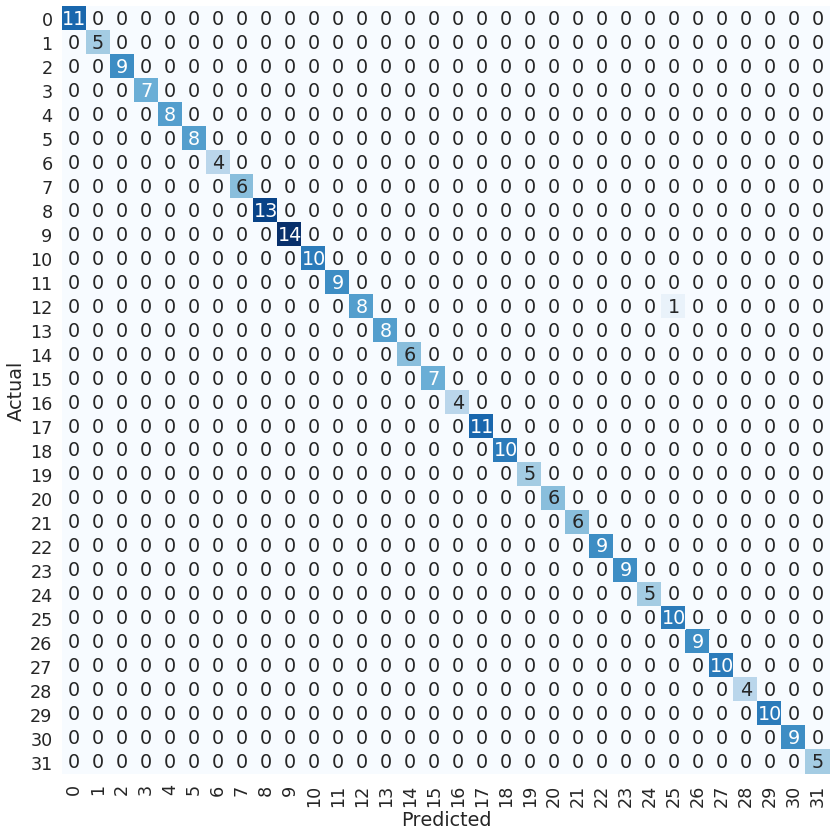

In [37]:
import seaborn as sn
array = interp.confusion_matrix()
df_cm = pd.DataFrame(array, index = [i for i in range(32)],
                  columns = [i for i in range(32)])
plt.figure(figsize = (12,12))

sn.set(font_scale=1.6)
ax=sn.heatmap(df_cm, annot=True, cbar=False, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()

In [33]:
fig=ax.get_figure()
fig.savefig("OMA_confmat.pdf",dpi=600,bbox_inches="tight")

In [33]:
learn.data.stats

[tensor([0.3104, 0.6820, 0.8254]), tensor([0.3438, 0.1833, 0.1699])]

In [34]:
# interp.plot_confusion_matrix(figsize=(9,9), normalize=False)
# ax = plt.subplot()
# for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(20)

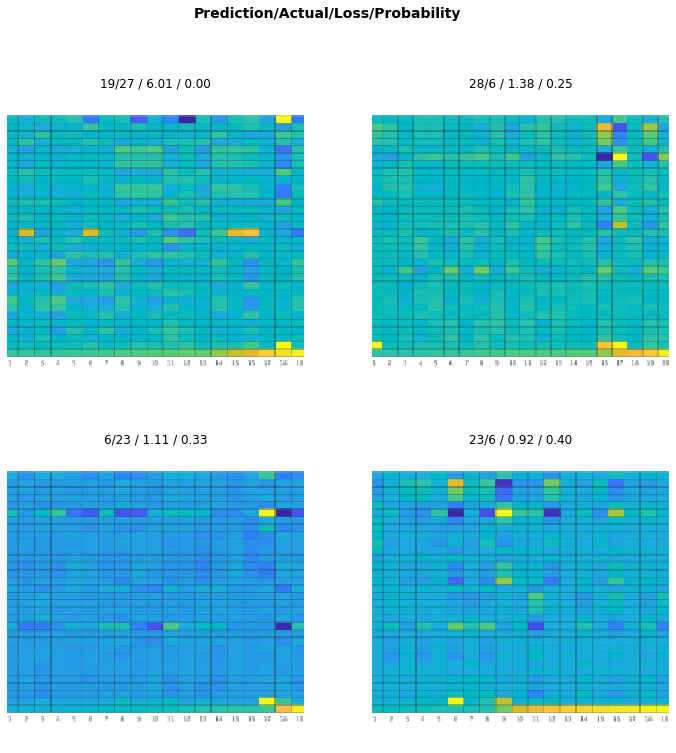

In [35]:
interp.plot_top_losses(4)

In [266]:
data = (src.transform(tfms, size=1024)
        .databunch(bs=4).normalize())

In [267]:
learn.data=data

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


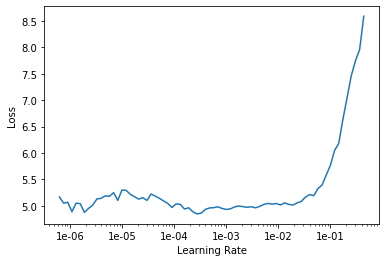

In [268]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [269]:
learn.fit_one_cycle(1, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.288206,1.330235,0.679688,01:05


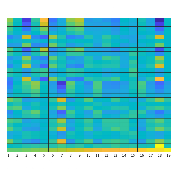

In [293]:
idx=5
x,y = data.valid_ds[idx]
x.show()

In [294]:
m = learn.model.eval();
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [295]:
from fastai.callbacks.hooks import *

In [296]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [297]:
hook_a,hook_g = hooked_backward()

In [298]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 32, 32])

In [299]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([32, 32])

In [304]:
def show_heatmap(hm,filename):
    _,ax = plt.subplots(figsize=(10,10))
    xb_im.show(ax)
    ax.set_title('OMA Focus Map', fontsize=20)
    ax.imshow(hm, alpha=0.7, extent=(-5*2,520*2,480*2,20*2), #this is werid with resize...
              interpolation='bilinear', cmap='magma');
    plt.savefig(filename, dpi=600, bbox_inches='tight')

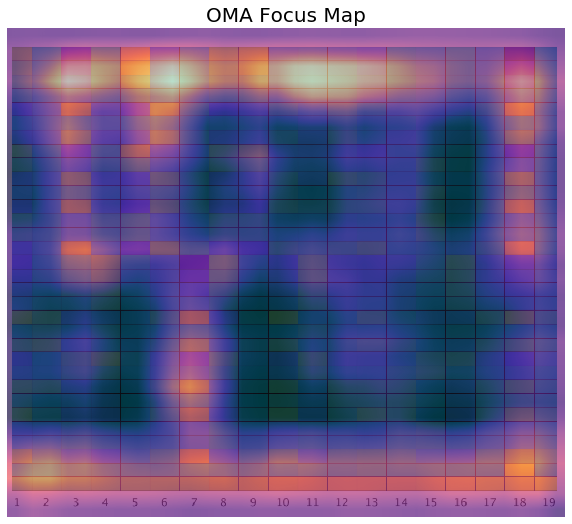

In [305]:
show_heatmap(avg_acts,'OMA_focalmap.png')

In [77]:
# fig.savefig("OMA_confmat.pdf",dpi=600,bbox_inches="tight")

In [ ]:
# for idx in range(0,200):
#     x,y = src.valid_ds[idx]
#     xb,_ = src.one_item(x)
#     xb_im = Image(src.denorm(xb)[0])
#     xb = xb.cuda()
#     hook_a,hook_g = hooked_backward()
#     acts  = hook_a.stored[0].cpu()
#     avg_acts = acts.mean(0)
#     filename='heatmap_'+str(idx)+'.png'
#     show_heatmap(avg_acts,filename)
    

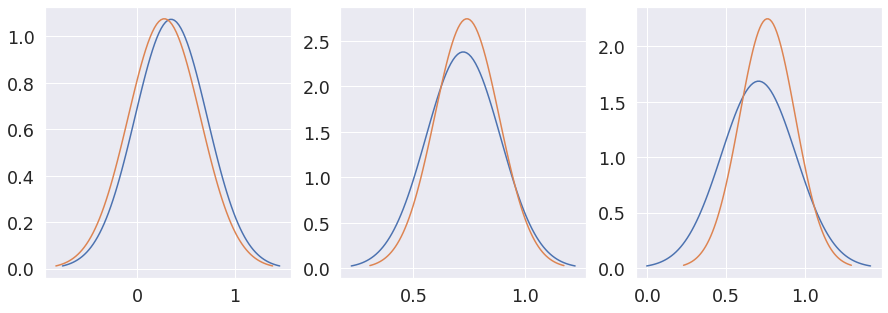

In [66]:
import scipy.stats as stats

# variance = 1
# sigma = math.sqrt(variance)
mu = 0.346
sigma = 0.3714

mu2=0.2759
sigma2=0.3706

mu3=0.7235
sigma3=0.1677

mu4=0.7402
sigma4=0.1454

mu5=0.7057
sigma5=0.2365

mu6=0.7618
sigma6=0.1773

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x2=np.linspace(mu2 - 3*sigma2, mu2 + 3*sigma2, 100)

x3 = np.linspace(mu3 - 3*sigma3, mu3 + 3*sigma3, 100)
x4=np.linspace(mu4 - 3*sigma4, mu4 + 3*sigma4, 100)

x5 = np.linspace(mu5 - 3*sigma5, mu5 + 3*sigma5, 100)
x6=np.linspace(mu6 - 3*sigma6, mu6 + 3*sigma6, 100)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))

ax1.plot(x, stats.norm.pdf(x, mu, sigma))
ax1.plot(x2, stats.norm.pdf(x2, mu2, sigma2))
ax2.plot(x3, stats.norm.pdf(x3, mu3, sigma3))
ax2.plot(x4, stats.norm.pdf(x4, mu4, sigma4))
ax3.plot(x5, stats.norm.pdf(x5, mu5, sigma5))
ax3.plot(x6, stats.norm.pdf(x6, mu6, sigma6))
plt.show()

Was thinking about adding this to paper. Normalized average pixel values and SD if normally distributed. DMD shows higher SD, but not sure it's significant enough in this representation...